# Parameter Initialization

In [14]:
import torch
import torchsummary
import torchvision

from matplotlib import pyplot as plt

## Constants

In [7]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
N_EPOCHS = 10
TRAIN_VAL_SPLIT = [55000, 5000]

## Loading the Data

In [8]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])

train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

train_set, val_set = torch.utils.data.random_split(train_set, TRAIN_VAL_SPLIT)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

## Defining the model

In [9]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=7,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Conv2d(
                in_channels=7,
                out_channels=19,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Conv2d(
                in_channels=19,
                out_channels=31,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features=31*32*32,
                out_features=1024,
            ),
            torch.nn.Tanh(),
            torch.nn.Linear(
                in_features=1024,
                out_features=10,
            )
        )

    
    def forward(self, x):
        return self.network(x)

In [10]:
model = Model()

torchsummary.summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 32, 32]              70
              Tanh-2            [-1, 7, 32, 32]               0
            Conv2d-3           [-1, 19, 32, 32]           1,216
              Tanh-4           [-1, 19, 32, 32]               0
            Conv2d-5           [-1, 31, 32, 32]           5,332
              Tanh-6           [-1, 31, 32, 32]               0
           Flatten-7                [-1, 31744]               0
            Linear-8                 [-1, 1024]      32,506,880
              Tanh-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
Total params: 32,523,748
Trainable params: 32,523,748
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.15
Params size (MB): 124.07
Est

In [11]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Baseline

In [12]:
accuracy_hist = []
loss_hist = []
val_accuracy_hist = []
val_los_hist = []

for epoch in range(N_EPOCHS):
    training_cost = 0.0
    training_correct = 0.0
    validation_cost = 0.0
    validation_correct = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        cost = loss_func(predictions, targets)
        cost.backward()
        optimizer.step()
        training_cost += cost.item()
        training_correct += (torch.argmax(predictions, dim=1) == targets).sum()
    training_cost /= len(train_set)
    training_correct /= len(train_set)
    print(f'epoch: {epoch}, loss: {training_cost}, accuracy: {training_correct}')
    accuracy_hist.append(training_correct)
    loss_hist.append(training_cost)

    with torch.no_grad():
        for inputs, targets in val_loader:
            predictions = model(inputs)
            cost = loss_func(predictions, targets)
            validation_cost += cost.item()
            validation_correct += (torch.argmax(predictions, dim=1) == targets).sum()
        validation_cost /= len(val_set)
        validation_correct /= len(val_set)
        print(f'Validation: loss: {validation_cost}, accuracy: {validation_correct}')
        val_accuracy_hist.append(validation_correct)
        val_los_hist.append(validation_cost)

epoch: 0, loss: 0.005628733582388271, accuracy: 0.7466182112693787
Validation: loss: 0.004626424211263656, accuracy: 0.7983999848365784
epoch: 1, loss: 0.004289439837499099, accuracy: 0.7986181974411011
Validation: loss: 0.004278032451868057, accuracy: 0.8094000220298767
epoch: 2, loss: 0.0041192753293297505, accuracy: 0.8062363862991333
Validation: loss: 0.00417198965549469, accuracy: 0.8058000206947327
epoch: 3, loss: 0.0040453370023857465, accuracy: 0.8114727139472961
Validation: loss: 0.0042082316160202025, accuracy: 0.7929999828338623
epoch: 4, loss: 0.003925998159430244, accuracy: 0.8154727220535278
Validation: loss: 0.004271244305372238, accuracy: 0.8116000294685364
epoch: 5, loss: 0.003871896010095423, accuracy: 0.8184363842010498
Validation: loss: 0.004265485435724258, accuracy: 0.8041999936103821
epoch: 6, loss: 0.0037924869819120927, accuracy: 0.8210726976394653
Validation: loss: 0.0038884996592998505, accuracy: 0.8136000037193298
epoch: 7, loss: 0.003782108034870841, accura

## Training Visualization

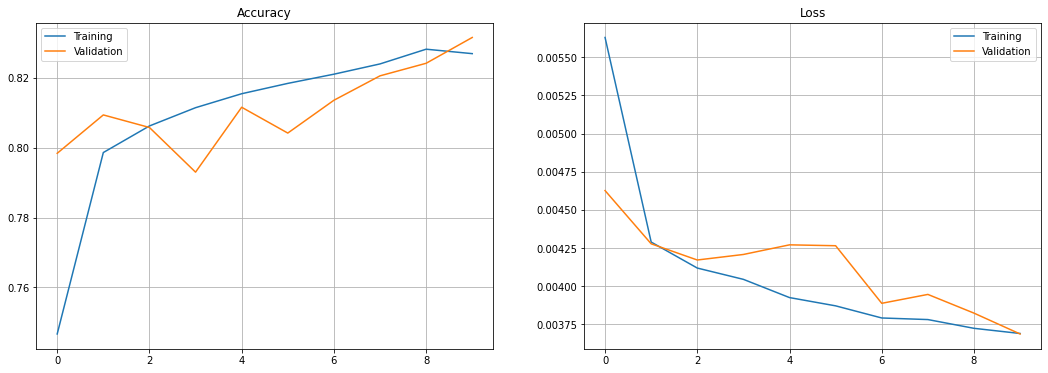

In [15]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(accuracy_hist, label='Training')
ax1.plot(val_accuracy_hist, label='Validation')
ax1.title.set_text('Accuracy')
ax1.legend()
ax1.grid()
ax2.plot(loss_hist, label='Training')
ax2.plot(val_los_hist, label='Validation')
ax2.title.set_text('Loss')
ax2.legend()
ax2.grid()